# Dataset analysis

## Common premable

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch

from toyDb.databases.ExperimentDb import (
    Environment,
    ImageOnlyExperiment,
    ImageOnlyResource,
    ImageOnlyShader,
    ImageOnlyTrace
)

ExperimentDb.init_from_default_db()

## experiments.db & ShaderDb analysis

This analysis is focused on
- Different (w, h) pairs
- Same environment
- No augmentation
- Canonical num cycles and num trials
- resource that have `iTime=1` and `iFrame=1`

In [2]:
shaderDB = ShaderDb.ShaderDB(os.path.join(getToyDbRootDir(), "shaders"))
shaderDB.scan_local()
shaderDB.load_all()

all_shaders = set(shaderDB.offlineShaders.keys())
imageonly_shaders = shaderDB.filter_attribute(["is_imageonly"])

# all environments available in database
all_environments = Environment.select()

all_resources = ImageOnlyResource.select()

environment_selected = all_environments[0]
print(f"Environment selected: {environment_selected.node} - {environment_selected.cpu} - {environment_selected.gpu} - {environment_selected.gpu_driver}")

resource_selected = []
for resource in all_resources:
    unpacked = ExperimentDb.unpackUniformResource(resource.uniform_block)
    if unpacked["iTime"] == 1 and unpacked["iFrame"] == 1:
        resource_selected.append(resource.id)

print(f"Resource selected: {resource_selected}")

additional_filters = [
    ImageOnlyExperiment.environment == environment_selected,
    ImageOnlyExperiment.augmentation == 0,
    ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
    ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
    ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
    ImageOnlyExperiment.resource.in_(resource_selected)
]

additional_filters_might_error = [
    ImageOnlyExperiment.environment == environment_selected,
    ImageOnlyExperiment.augmentation == 0,
    ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
    ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
    (ImageOnlyExperiment.resource.in_(resource_selected) | ImageOnlyExperiment.resource.is_null(True))
]

# 1. Report the (w, h) pairs present in a database
wh_groups = ImageOnlyExperiment.select(
    ImageOnlyExperiment.width, ImageOnlyExperiment.height
).group_by(
    ImageOnlyExperiment.width, ImageOnlyExperiment.height
).dicts()

print(f"All possible (width, height):")
for expr in wh_groups:
    print(f"- {expr['width']} x {expr['height']}")

Environment selected: libreliu-GCL-Arch -  Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz - NVIDIA GeForce RTX 3060 - NVIDIA 535.113.01
Resource selected: [1, 2, 3]
All possible (width, height):
- 800 x 600
- 1024 x 768
- 1920 x 1080


In [3]:
# 2. Find shader runs that have trace & time readings across all possible (w, h) groups
#    for a given environment

# shaders that have at least 1 non-error measurement and satisfy filter conditions
measurable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id
    ).join(ImageOnlyExperiment).where(
      *additional_filters
    ).distinct()
])

# shaders that have measurements in all (w, h) pairs tested
all_measurable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id,
      ImageOnlyExperiment.width,
      ImageOnlyExperiment.height
    ).join(ImageOnlyExperiment).group_by(
      ImageOnlyShader.shader_id
    ).having(
      pw.fn.COUNT(pw.SQL('*')) == len(wh_groups)
    ).where(*additional_filters)
])

In [4]:
def analyzeFailedShaders(failed_shaders: 'set'):
    for failed_shader in failed_shaders:
        print(f"- Analysis for shader {failed_shader} (https://shadertoy.com/view/{failed_shader}):")
        exprQuery = ImageOnlyExperiment.select(
            ImageOnlyShader.shader_id,
            ImageOnlyExperiment.width,
            ImageOnlyExperiment.height,
            ImageOnlyExperiment.results,
            ImageOnlyExperiment.trace,
            pw.fn.COUNT(pw.SQL('*'))
        ).join(ImageOnlyShader).group_by(
            ImageOnlyExperiment.width,
            ImageOnlyExperiment.height
        ).where(
            ImageOnlyShader.shader_id == failed_shader,
            *additional_filters
        )
        # print(exprQuery)
        exprs = [i for i in exprQuery]

        for whInfo in wh_groups:
            found = False
            for expr in exprs:
                if whInfo["width"] == expr.width and whInfo["height"] == expr.height:
                    timeResult = np.asarray(json.loads(expr.results))
                    print(
                        f"  - {expr.width} x {expr.height}: \n"
                        f"    - timeMean={np.mean(timeResult)}\n"
                        f"    - timeStd={np.std(timeResult)}\n"
                        f"    - trace={expr.trace}"
                    )
                    found = True
            if not found:
                cands = ImageOnlyExperiment.select().where(
                    ImageOnlyExperiment.shader_shadertoy_id == failed_shader,
                    ImageOnlyExperiment.width == whInfo["width"],
                    ImageOnlyExperiment.height == whInfo["height"],
                    *additional_filters_might_error
                )
                if len(cands) == 0:
                    print(f"  - {whInfo['width']} x {whInfo['height']}: Not found")
                elif len(cands) > 1:
                    print(f"  - {whInfo['width']} x {whInfo['height']}: Multiple error'ed found")
                else:
                    print(f"  - {whInfo['width']} x {whInfo['height']}: error={cands[0].errors}")

In [5]:
print(f"Number of shaders in Shadertoy Offline Database: {len(all_shaders)}")
print(f"Number of ImageOnly shaders: {len(imageonly_shaders)}")
print(f"Number of environments: {len(all_environments)}")

print(f"Number of measurable shaders: {len(measurable_shaders)}")
print(f"Number of all measurable shaders: {len(all_measurable_shaders)}")

# Print analysis for each of the shader that failed the group
analyzeFailedShaders(measurable_shaders - all_measurable_shaders)

Number of shaders in Shadertoy Offline Database: 0
Number of ImageOnly shaders: 0
Number of environments: 2
Number of measurable shaders: 13887
Number of all measurable shaders: 13864
- Analysis for shader Ds23Wd (https://shadertoy.com/view/Ds23Wd):
  - 800 x 600: 
    - timeMean=5.5326719999999995e-05
    - timeStd=2.8353276118760615e-08
    - trace=14204
  - 1024 x 768: error=2
  - 1920 x 1080: error=2
- Analysis for shader XlV3Wm (https://shadertoy.com/view/XlV3Wm):
  - 800 x 600: error=2
  - 1024 x 768: 
    - timeMean=0.00016679936000000003
    - timeStd=5.514408762505978e-08
    - trace=8271
  - 1920 x 1080: 
    - timeMean=0.00043506346666666665
    - timeStd=5.5038346228397866e-08
    - trace=40746
- Analysis for shader llVGRc (https://shadertoy.com/view/llVGRc):
  - 800 x 600: error=2
  - 1024 x 768: 
    - timeMean=1.7121280000000004e-05
    - timeStd=2.2641491902159733e-08
    - trace=6431
  - 1920 x 1080: error=2
- Analysis for shader XtXBzs (https://shadertoy.com/view/XtXB

In [6]:
measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id
    ).join(ImageOnlyExperiment).where(
      *additional_filters,
      ImageOnlyExperiment.trace.is_null(False)
    ).distinct()
])

# shaders that have measurements in all (w, h) pairs tested
all_measurable_and_traceable_shaders_query = ImageOnlyShader.select(
      ImageOnlyShader.shader_id,
      ImageOnlyExperiment.width,
      ImageOnlyExperiment.height
    ).join(ImageOnlyExperiment).group_by(
      ImageOnlyShader.shader_id
    ).having(
      pw.fn.COUNT(pw.SQL('*')) == len(wh_groups)
    ).where(
      *additional_filters,
      ImageOnlyExperiment.trace.is_null(False)
)

all_measurable_and_traceable_shaders = set([
    shdr.shader_id for shdr in all_measurable_and_traceable_shaders_query
])

In [7]:
print(f"Number of measurable and traceable shaders: {len(measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable shaders: {len(all_measurable_and_traceable_shaders)}")
print()
print(f"Analysis for those that are all measurable but not (all) traceable")

analyzeFailedShaders(measurable_and_traceable_shaders - all_measurable_and_traceable_shaders)

Number of measurable and traceable shaders: 13886
Number of all measurable and traceable shaders: 13852

Analysis for those that are all measurable but not (all) traceable
- Analysis for shader Nl2yWm (https://shadertoy.com/view/Nl2yWm):
  - 800 x 600: 
    - timeMean=0.006882583893333333
    - timeStd=2.2083923747982315e-06
    - trace=17116
  - 1024 x 768: 
    - timeMean=0.011171160746666667
    - timeStd=3.140320463307202e-06
    - trace=11564
  - 1920 x 1080: 
    - timeMean=0.02924867584
    - timeStd=3.979595364713262e-06
    - trace=None
- Analysis for shader 3s3SDn (https://shadertoy.com/view/3s3SDn):
  - 800 x 600: 
    - timeMean=0.07147887616000001
    - timeStd=2.937450512274979e-05
    - trace=16391
  - 1024 x 768: 
    - timeMean=0.11580438869333334
    - timeStd=2.3136136591940937e-05
    - trace=13610
  - 1920 x 1080: 
    - timeMean=0.30264609450666663
    - timeStd=3.5707877621728785e-05
    - trace=None
- Analysis for shader ld3cWj (https://shadertoy.com/view/ld3cWj

In [8]:
measurable_shaders - measurable_and_traceable_shaders

{'Nd33Dr'}

In [9]:
measurable_and_traceable_shaders - all_measurable_and_traceable_shaders

{'3lVSDt',
 '3s3SDn',
 '3slfzs',
 '3tdGRj',
 '4ddXDs',
 '4llSzS',
 '7tlyDs',
 'Ds23Wd',
 'MdKBWV',
 'MsKyDR',
 'NdfXR7',
 'Nl2yWm',
 'NtVfDh',
 'Wd2yWt',
 'WtVSDt',
 'XdffR2',
 'XlV3Wm',
 'XtXBzs',
 'dlc3Wl',
 'dttGRM',
 'ftjBzG',
 'ld33RX',
 'ld3cWj',
 'llVGRc',
 'llfSzH',
 'msc3W2',
 'sd2cW3',
 'sd3XWX',
 'stSSWW',
 'tddXzl',
 'tlB3R1',
 'ws2GDt',
 'wsVfzD',
 'wsfyDs'}

## Time-shift analysis

Analysis the shift of time as time goes.

In [10]:
timeMeasured = np.zeros((len(wh_groups), len(all_measurable_and_traceable_shaders), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.double)

# ((w,h), shader_id in string)
exprFilled = set()

# iterate over experiment to fill in the blank
# https://stackoverflow.com/questions/33901178/translating-sql-sub-query-to-peewee-orm
wh_groups_ordered = [
    (elem["width"], elem["height"])
    for elem in wh_groups
]

for subgroupIdx, (w, h) in enumerate(wh_groups_ordered):
    query = ImageOnlyExperiment.select().join(ImageOnlyShader).where(
        *additional_filters,
        ImageOnlyExperiment.width == w,
        ImageOnlyExperiment.height == h
    ).join(all_measurable_and_traceable_shaders_query, on=(
        (ImageOnlyShader.shader_id == all_measurable_and_traceable_shaders_query.c.shader_id)
    )).order_by(
        # THIS IS IMPORTANT! ENSURE OUR DATA IS IN ORDER
        ImageOnlyExperiment.shader_shadertoy_id.asc()
    )
    assert(len(query) == len(all_measurable_and_traceable_shaders))

    curIdx = 0
    for expr in query:
        results = np.asarray(json.loads(expr.results), dtype=np.double)
        
        timeMeasured[subgroupIdx, curIdx, :] = results
        curIdx += 1

    assert(curIdx == len(all_measurable_and_traceable_shaders))

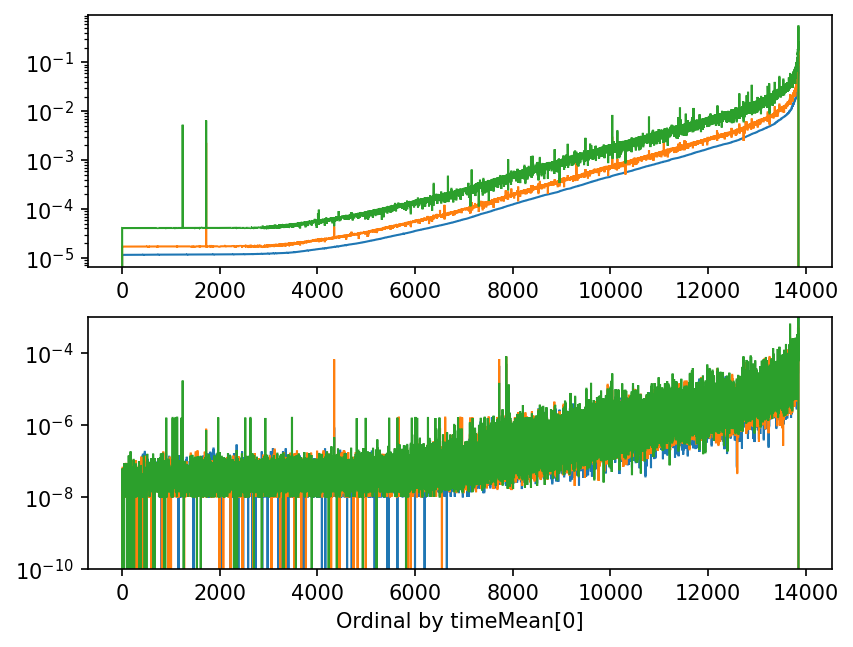

In [11]:
# (wh_groups, shaderIdx)
timeMean = np.mean(timeMeasured, axis=2)
timeStdev = np.std(timeMeasured, axis=2)
min_wh = min(wh_groups_ordered)
min_wh_idx = wh_groups_ordered.index(min_wh)

# sort w.r.t. the min w/h array; returns (n_shaders,)
indices = np.argsort(timeMean[min_wh_idx, :])
timeMeanSorted = timeMean[:, indices]
timeStdevSorted = timeStdev[:, indices]

plt.rcParams['figure.dpi'] = 150
fig, (axMean, axStd) = plt.subplots(2, 1)

axMean.set_yscale('log')
axStd.set_yscale('log')
axStd.set_xlabel('Ordinal by timeMean[0]')
axStd.set_ylim(bottom=1e-10, top=1e-3)

for groupIdx in range(len(wh_groups_ordered)):
    axMean.stairs(timeMeanSorted[groupIdx, :])
    axStd.stairs(timeStdevSorted[groupIdx, :])
    